In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import torch
import re
import tensorflow as tf
from collections import Counter
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO
from google.colab import drive
from google.colab.patches import cv2_imshow
from tensorflow.keras.applications import MobileNetV2
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

##Def

In [4]:
def extract_ids(image_folder:str, ann_file:str):
  """
    return final_ids which is in pic and ann file
    image_folder: path to the image folder
    ann_file: path to the annotation file

  """
  coco = COCO(ann_file)
  # List of ids in ann
  img_ids = coco.getImgIds()

  # path of images
  image_list = os.listdir(image_folder)
  id_list = []
  for image_name in image_list:
    if image_name.endswith(".jpg") or image_name.endswith(".jpeg"):
      # Extracting ID using regular expression
      match = re.search(r'\d+', image_name)
      if match:
        image_id = int(match.group())
        id_list.append(image_id)

  # Intersection of two list
  final_id = list(set(img_ids) & set(id_list))

  return final_id

def one_label_COCO(image_folder:str, ann_file:str, main_labels:dict):
  """
    return image id and uniq label (Select the class with the largest number of objects)
    which filtered by main_label and return sorted list of keys
    image_folder: path to the image folder
    ann_file: path to the annotation file
    main_labels: main labels we need (must be in {})
  """
  # retirn final_ids which is in pic and ann file
  image_ids = extract_ids(image_folder, ann_file)
  # Define coco
  coco = COCO(ann_file)

  # Create a dictionary to store the final labels
  img_to_label = {}

  # Processing each image
  for img_id in image_ids:
      # Get image annotations
      ann_ids = coco.getAnnIds(imgIds=img_id)
      anns = coco.loadAnns(ann_ids)

      # Count the number of objects of each class
      class_counts = {}
      for ann in anns:
          class_id = ann['category_id']
          class_counts[class_id] = class_counts.get(class_id, 0) + 1

      # Select the class with the largest number of objects.
      if class_counts:
          dominant_class = max(class_counts, key=class_counts.get)
          img_to_label[img_id] = dominant_class
      else:
          img_to_label[img_id] = None  # If the image has no objects

  ## Print number of label
  #lebel count
  lebel_counts = Counter(img_to_label.values())
  # Convert to list of tuples and sort by count (highest to lowest)
  sorted_value_counts = sorted(lebel_counts.items(), key=lambda x: x[1], reverse=True)
  #print them
  for value, count in sorted_value_counts:
      print(f"Value = {value}: {count} times")

  #filtered by labels
  filtered_dict = {k: v for k, v in img_to_label.items() if v in main_labels}
  #Sort Dict by id
  filtered_dict = dict(sorted(filtered_dict.items()))
  #Sorted Key list
  sorted_keys_list = sorted(filtered_dict.keys())

  return filtered_dict, sorted_keys_list

def onehot_labels(my_dict:dict, num_classes:int):
  """
  changes the dictionary which has id and classes to one hot array
  my_dict: main dictionary
  num_classes: number of classes
  """
  # Number of classes
  num_classes = num_classes
  # Create a 2D array of the form (number of data, num_classes)
  num_data = len(my_dict)
  onehot_array = np.zeros((num_data, num_classes))
  # Converting a dictionary to a one-hot two-dimensional array
  for idx, (key, val) in enumerate(my_dict.items()):
      onehot_array[idx][val] = 1
  return onehot_array


def pic_preproc_Intersection(image_folder:str, ann_file:str, main_labels:dict, size: int):
  """
  resize and add 1 dimention to the image.  return just Intersection images.
  image_folder: path to the image folder
  ann_file: path to the annotation file
  main_labels: main labels we need (must be in {})
  size: size of Length and width
  """
  _,id_Intersection = one_label_COCO(image_folder, ann_file, main_labels)
  # A list to save the paths of the desired images
  filtered_image_paths = []

  # Reading image paths
  image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.lower().endswith(".jpg")]

  # Filter image paths based on IDs in id_Intersection
  for image_path in image_paths:
      image_name = os.path.basename(image_path)
      id_number = int(image_name.split('.')[0])  #Extracting ID from image name
      if id_number in id_Intersection:
          filtered_image_paths.append(image_path)  # Add image path to filtered list
  # Sort the path
  filtered_image_paths.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
  print(filtered_image_paths)
  #####Preprocess function
  all_images = []
  # main function
  for img_path in filtered_image_paths:
      img = cv2.imread(img_path)
      gray_img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      resized_img = cv2.resize(gray_img1, (size, size))
      gray_img2 = resized_img[:, :, np.newaxis]
      # Normalize pixel values to be between 0 and 1
      gray_img2 = gray_img2 / 255.0

      # Add processed image to list
      all_images.append(gray_img2)
  # Convert list to NumPy array
  all_pic = np.array(all_images)

  return all_pic

def pic_preproc_Intersection_3chan(image_folder:str, ann_file:str,main_labels:dict, size: int):
  """
  resize the image.  return just Intersection images.
  image_folder: path to the image folder
  ann_file: path to the annotation file
  main_labels: main labels we need (must be in {})
  size: size of Length and width
  """
  _,id_Intersection = one_label_COCO(image_folder, ann_file, main_labels)
  # A list to save the paths of the desired images
  filtered_image_paths = []

  # Reading image paths
  image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.lower().endswith(".jpg")]

  # Filter image paths based on IDs in id_Intersection
  for image_path in image_paths:
      image_name = os.path.basename(image_path)
      id_number = int(image_name.split('.')[0])  #Extracting ID from image name
      if id_number in id_Intersection:
          filtered_image_paths.append(image_path)  # Add image path to filtered list
  # Sort the path
  filtered_image_paths.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
  print(filtered_image_paths)
  #####Preprocess function
  all_images = []
  # main function
  for img_path in filtered_image_paths:
      img = cv2.imread(img_path)
      resized_img = cv2.resize(img, (size, size))
      # Normalize pixel values to be between 0 and 1
      resized_img = resized_img / 255.0
      # Add processed image to list
      all_images.append(resized_img)
  # Convert list to NumPy array
  all_pic = np.array(all_images)

  return all_pic

def train_test_splitt(x_all:np.ndarray, y_all:np.ndarray, test_ratio:float):
  """
  split train and test. for x and y
  x_all: x data (input pic)
  y_all: y data (label)
  test_ratio:  test ratio (float)
  """
  # Splitting the data into train and test with a ratio of 80 to 20 percent
  x_train, x_test, y_train, y_test,  = train_test_split(x_all,y_all, test_size=test_ratio , random_state=42)
  return x_train, x_test, y_train, y_test


In [5]:
# def property
image_folder = "/content/drive/MyDrive/Ai_Lab/data/coco/val2017"
ann_file = '/content/drive/MyDrive/Ai_Lab/data/coco/annotations_small/instances_val2017.json'
main_labels = {1, 3, 62, 44,17,84,18,16,70}
size = 224
num_classes = 183

In [6]:
##Run Function
#Y
filtered_dict,sorted_keys_list = one_label_COCO(image_folder, ann_file, main_labels)
my_dict = filtered_dict
y_all=onehot_labels(my_dict, num_classes)

loading annotations into memory...
Done (t=3.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
Value = 1: 1564 times
Value = 3: 241 times
Value = 62: 156 times
Value = 44: 129 times
Value = 17: 115 times
Value = 84: 111 times
Value = 18: 109 times
Value = 16: 88 times
Value = 70: 85 times
Value = 25: 82 times
Value = 85: 80 times
Value = 24: 74 times
Value = 7: 74 times
Value = 19: 73 times
Value = 10: 69 times
Value = 47: 68 times
Value = 21: 64 times
Value = 5: 59 times
Value = 22: 59 times
Value = 51: 55 times
Value = 65: 54 times
Value = 52: 53 times
Value = 59: 51 times
Value = 9: 50 times
Value = 4: 50 times
Value = 20: 49 times
Value = 77: 49 times
Value = None: 48 times
Value = 37: 48 times
Value = 88: 48 times
Value = 56: 48 times
Value = 32: 46 times
Value = 54: 45 times
Value = 72: 44 times
Value = 57: 44 times
Value = 15: 43 times
Value = 23: 42 times
Value = 64: 39 times
Value = 63: 38 times
Value = 28:

In [7]:
#X
x_all = pic_preproc_Intersection_3chan(image_folder, ann_file,main_labels, size)

loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
Value = 1: 1564 times
Value = 3: 241 times
Value = 62: 156 times
Value = 44: 129 times
Value = 17: 115 times
Value = 84: 111 times
Value = 18: 109 times
Value = 16: 88 times
Value = 70: 85 times
Value = 25: 82 times
Value = 85: 80 times
Value = 24: 74 times
Value = 7: 74 times
Value = 19: 73 times
Value = 10: 69 times
Value = 47: 68 times
Value = 21: 64 times
Value = 5: 59 times
Value = 22: 59 times
Value = 51: 55 times
Value = 65: 54 times
Value = 52: 53 times
Value = 59: 51 times
Value = 9: 50 times
Value = 4: 50 times
Value = 20: 49 times
Value = 77: 49 times
Value = None: 48 times
Value = 37: 48 times
Value = 88: 48 times
Value = 56: 48 times
Value = 32: 46 times
Value = 54: 45 times
Value = 72: 44 times
Value = 57: 44 times
Value = 15: 43 times
Value = 23: 42 times
Value = 64: 39 times
Value = 63: 38 times
Value = 28:

In [8]:
x_al=x_all
y_al = y_all
test_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_splitt(x_al, y_al, test_ratio)

min_pixel_value = 0
max_pixel_value = 1
print ("min_pixel_value =" , min_pixel_value, "," , "max_pixel_value =" , max_pixel_value)
print ("x_train.shape =" , x_train.shape, "," , "y_train =" , y_train.shape)

min_pixel_value = 0 , max_pixel_value = 1
x_train.shape = (2078, 224, 224, 3) , y_train = (2078, 183)


# Model

## MobileNetV2

In [ ]:
#model = MobileNetV2(weights=None, input_shape=(224, 224, 3), classes=num_classes)

### CNN2D

In [10]:
# CNN2D model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(183, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile and evaluate the model

In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 183)                 │          93,879 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,772,407 (37.28 MB)

 Trainable params: 9,772,407 (37.28 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Model training
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 214ms/step - accuracy: 0.5718 - loss: 2.2483 - val_accuracy: 0.5635 - val_loss: 1.5570
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6114 - loss: 1.5209 - val_accuracy: 0.5635 - val_loss: 1.5384
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.6010 - loss: 1.4807 - val_accuracy: 0.5635 - val_loss: 1.5289
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.6099 - loss: 1.4363 - val_accuracy: 0.5635 - val_loss: 1.4796
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.6090 - loss: 1.3520 - val_accuracy: 0.5635 - val_loss: 1.5025
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5954 - loss: 1.3179 - val_accuracy: 0.5673 - val_loss: 1.4577
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6170 - loss: 1.1824 - val_accuracy: 0.5615 - val_loss: 1.4713
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6614 - loss: 0.9841 - val_accuracy: 0.5346 -

In [13]:
# Model evaluation
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"test_acc: {test_acc:.4f}")

17/17 - 0s - 25ms/step - accuracy: 0.5231 - loss: 5.3254
test_acc: 0.5231


# Models

#Make ADV

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [15]:
# Helper function to preprocess the image
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image


In [16]:
image_path =  "/content/drive/MyDrive/Ai_Lab/data/Yazdanian/simple/51101054.jpg"
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = preprocess(image)
image_probs = model.predict(image)

print("image.shape:", image.shape)
print("image_probs.shape:", image_probs.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
image.shape: (1, 224, 224, 3)
image_probs.shape: (1, 183)


In [17]:
# Get the input label of the image.
#True label of image
labrador_retriever_index = 1
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

In [18]:
def fgsm_attack(model, input_image, input_label,  epsilon):
  """
  Implementing the FGSM attack to create a destructive instance
  model: Deep learning model
  input_image: Input image (TensorFlow tensor)
  input_label: Correct label (TensorFlow tensor)
  epsilon: Attack intensity (ε)
  """
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = tf.keras.losses.CategoricalCrossentropy()(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  perturbations = signed_grad
  # add attack to the pic
  adv_x = image + epsilon*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  return adv_x, perturbations


def pgd_attack(model, input_image, input_label, epsilon, alpha, num_iterations):
  """
  Implementing the PGD attack to create a destructive instance
  model: Deep learning model
  input_image: Input image (TensorFlow tensor)
  input_label: Correct label (TensorFlow tensor)
  epsilon: Attack intensity (ε)
  alpha: Step size per iteration (α)
  num_iterations: Number of iterations (T).
  """
  # Destructive image initialization
  adversarial_image = input_image + tf.random.uniform(input_image.shape, -epsilon, epsilon)
  adversarial_image = tf.clip_by_value(adversarial_image, -1, 1)

  for _ in range(num_iterations):
      with tf.GradientTape() as tape:
          tape.watch(adversarial_image)
          prediction = model(adversarial_image)
          loss = tf.keras.losses.CategoricalCrossentropy()(input_label, prediction)

      # Calculating gradients
      gradient = tape.gradient(loss, adversarial_image)
      # Calculating the sign of gradients
      signed_grad = tf.sign(gradient)
      perturbations = signed_grad
      # Destructive image update
      adversarial_image = adversarial_image + alpha * signed_grad
      # Projecting within the permitted limits
      adversarial_image = tf.clip_by_value(adversarial_image, input_image - epsilon, input_image + epsilon)
      adversarial_image = tf.clip_by_value(adversarial_image, -1, 1)

  return adversarial_image, perturbations


def bim_attack(model, input_image, input_label, epsilon, alpha, num_iterations):
  """
  Implementing the BIM attack to create a destructive instance
  model: Deep learning model
  input_image: Input image (TensorFlow tensor)
  input_label: Correct label (TensorFlow tensor)
  epsilon: Attack intensity (ε)
  alpha: Step size per iteration (α)
  num_iterations: Number of iterations (T).
  """
  # Destructive image initialization
  adversarial_image = input_image

  for _ in range(num_iterations):
      with tf.GradientTape() as tape:
          tape.watch(adversarial_image)
          prediction = model(adversarial_image)
          loss = tf.keras.losses.CategoricalCrossentropy()(input_label, prediction)

      # Calculating gradients
      gradient = tape.gradient(loss, adversarial_image)
      # Calculating the sign of gradients
      signed_grad = tf.sign(gradient)
      perturbations = signed_grad
      # Destructive image update
      adversarial_image = adversarial_image + alpha * signed_grad
      # Projecting within the permitted limits
      adversarial_image = tf.clip_by_value(adversarial_image, input_image - epsilon, input_image + epsilon)
      adversarial_image = tf.clip_by_value(adversarial_image, -1, 1)

  return adversarial_image, perturbations


def mi_fgsm_attack(model, input_image, input_label, epsilon, alpha, num_iterations, momentum):
  """
  Implementing the MI_FGSM attack to create a destructive instance
  model: Deep learning model
  input_image: Input image (TensorFlow tensor)
  input_label: Correct label (TensorFlow tensor)
  epsilon: Attack intensity (ε)
  alpha: Step size per iteration (α)
  num_iterations: Number of iterations (T)
  momentum: Momentum parameter (μ)
  """

  # Destructive image initialization and cumulative gradient
  adversarial_image = input_image
  g = tf.zeros_like(input_image)

  for _ in range(num_iterations):
      with tf.GradientTape() as tape:
          tape.watch(adversarial_image)
          prediction = model(adversarial_image)
          loss = tf.keras.losses.CategoricalCrossentropy()(input_label, prediction)

      # Calculating gradients
      gradient = tape.gradient(loss, adversarial_image)
      # Normalizing gradients with L1 normal
      gradient_norm = tf.norm(gradient, ord=1)
      normalized_gradient = gradient / gradient_norm
      # Cumulative Gradient Update with Momentum
      g = momentum * g + normalized_gradient
      # Calculating the sign of the cumulative gradient
      signed_grad = tf.sign(g)
      perturbations = signed_grad
      # Destructive image update
      adversarial_image = adversarial_image + alpha * signed_grad
      # Projecting within the permitted limits
      adversarial_image = tf.clip_by_value(adversarial_image, input_image - epsilon, input_image + epsilon)
      adversarial_image = tf.clip_by_value(adversarial_image, -1, 1)

  return adversarial_image, perturbations

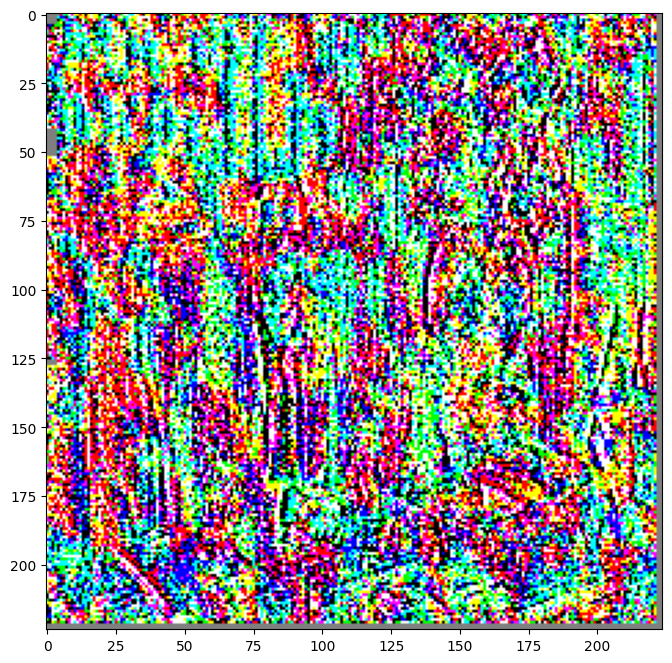

In [19]:
#RUN
model = model
input_image = image
input_label = label
epsilon = 0.02
alpha = epsilon / 4
num_iterations = 5
momentum = 0.9

adv_x, perturbations = fgsm_attack(model, input_image, input_label, epsilon)
#adv_x, perturbations = pgd_attack(model,  input_image, input_label, epsilon, alpha, num_iterations)
#adv_x, perturbations = bim_attack(model,  input_image, input_label, epsilon, alpha, num_iterations)
#adv_x, perturbations = mi_fgsm_attack(model, input_image, input_label, epsilon, alpha, num_iterations, momentum)

plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

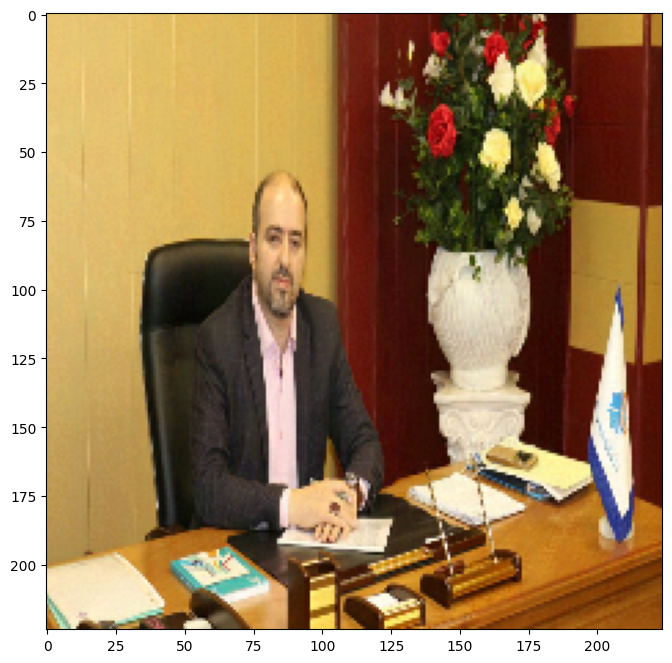

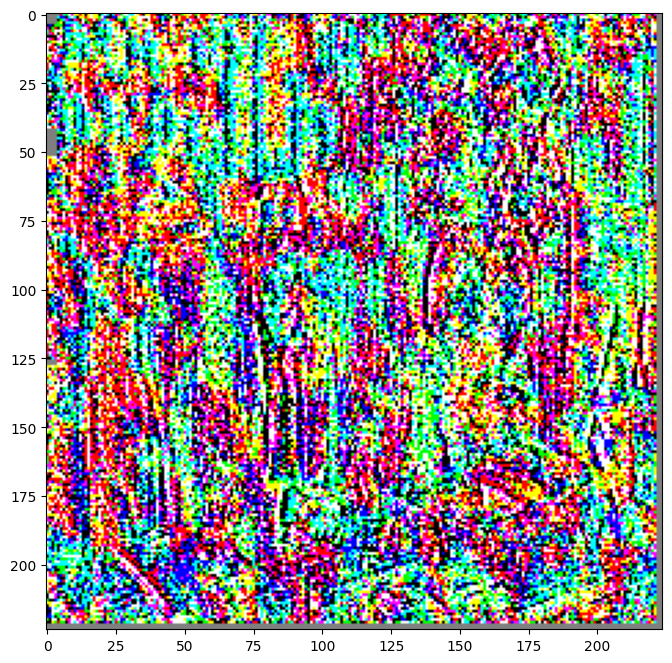

In [20]:

def display_images(adv_x, save_path):
  """
  display_images and save the pic
  adv_x: adversal image
  save_path: path to save the image (.jpg)
  """
  adv_x=adv_x[0]*0.5+0.5
  if save_path:
    plt.imsave(save_path, adv_x.numpy())
  plt.figure()
  plt.imshow(adv_x)
  plt.show()

adv_x = adv_x
save_path1 = '/content/drive/MyDrive/Ai_Lab/data/Yazdanian/yazdanian_attack_MI_FGSM/51101054.jpg'
save_path2 = '/content/drive/MyDrive/Ai_Lab/data/Yazdanian/yazdanian_attack_MI_FGSM/per_51101054.jpg'

display_images(adv_x, save_path1)
display_images(perturbations, save_path2)

